# In this notebook, I will import the csv I created of my results from the Google API and use the gathered latitude and longitude to turn it into a geodataframe. From there, I will merge it with the Davidson Census Tract geojson and use that to create some map visualizations. 

In [8]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point, LineString
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from itertools import combinations
%matplotlib inline

In [9]:
businesses = pd.read_csv('../data/businesses_in_pred_black_tracts.csv')
businesses.head()

,Unnamed: 0,name,type,latitude,longitude,tract
0,0,Shell,gas_station,36.252069,-86.829760,census_tract_10105
1,1,Cenex KCK's,gas_station,36.279847,-86.873683,census_tract_10105
2,2,Kroger Fuel Center,gas_station,36.210674,-86.838564,census_tract_10105
3,3,Brenda's Corner Market,convenience_store,36.280015,-86.873743,census_tract_10105
4,4,Kwik Sak,gas_station,36.218140,-86.836695,census_tract_10105


In [10]:
businesses.type.value_counts()

restaurant                388
point_of_interest         303
bar                       196
hospital                  179
gas_station               110
electronics_store          86
meal_takeaway              70
clothing_store             68
home_goods_store           53
car_dealer                 51
cafe                       50
pharmacy                   42
convenience_store          41
car_repair                 38
grocery_or_supermarket     36
meal_delivery              31
night_club                 30
health                     27
food                       26
furniture_store            25
drugstore                  25
store                      23
bakery                     22
shoe_store                 21
finance                    15
florist                    14
supermarket                14
liquor_store               12
tourist_attraction         12
jewelry_store              11
moving_company             11
general_contractor         10
movie_rental               10
beauty_sal

In [11]:
businesses['geometry'] = businesses.apply(lambda x: Point((x.longitude, 
                                                         x.latitude)), 
                                        axis=1) #code to create the geometry field
businesses.head(3)

,Unnamed: 0,name,type,latitude,longitude,tract,geometry
0,0,Shell,gas_station,36.252069,-86.829760,census_tract_10105,POINT (-86.8297597 36.2520693)
1,1,Cenex KCK's,gas_station,36.279847,-86.873683,census_tract_10105,POINT (-86.873683 36.279847)
2,2,Kroger Fuel Center,gas_station,36.210674,-86.838564,census_tract_10105,POINT (-86.8385638 36.2106742)


## Now I will read in the Davidson Census Tract geojson file and inspect it. 

In [35]:
davidson_tracts = gpd.read_file('../data/davidson_tracts_pred_black.geojson')
davidson_tracts.head(3)

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,asian_alon,asian_al_1,hawaiian_p,hawaiian_1,other_alon,other_al_1,two_or_mor,two_or_m_1,two_includ,two_incl_1,two_exclud,two_excl_1,white_pct,black_af_p,nativeam_2,asian_al_2,hawaiian_2,other_al_2,two_or_m_2,centroid,radius,buffer,geometry
0,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,0.0,12.0,0.0,12.0,49.0,78.0,102.0,85.0,12.0,20.0,90.0,82.0,0.218038,0.747914,0.0,0.000000,0.0,0.011048,0.022999,POINT (-86.85387694867056 36.24885011739272),3729.841782,4534.841782,"POLYGON ((-86.89144 36.26205, -86.89100 36.262..."
1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
2,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,14.0,17.0,0.0,17.0,503.0,454.0,102.0,67.0,0.0,17.0,102.0,67.0,0.085792,0.808630,0.0,0.002388,0.0,0.085792,0.017397,POINT (-86.76382269139667 36.24932859655561),1911.288764,2716.288764,"POLYGON ((-86.78518 36.23812, -86.78502 36.239..."


In [14]:
davidson_tracts.crs #checking the crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

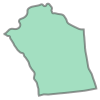

In [15]:
davidson_tracts.loc[0, 'geometry']

<AxesSubplot:>

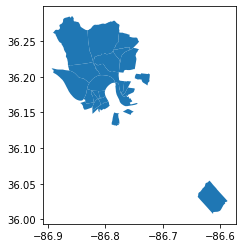

In [16]:
davidson_tracts.plot()

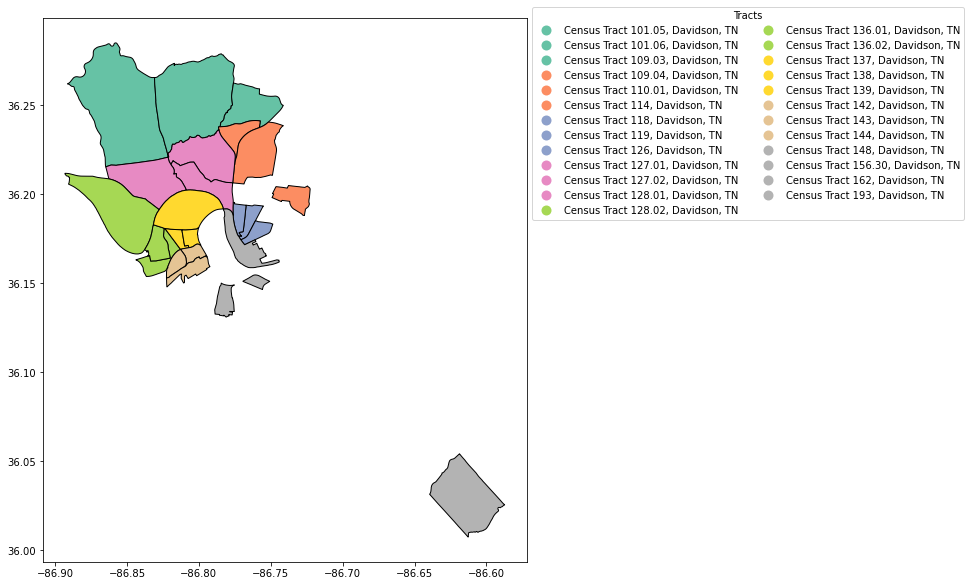

In [17]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Tracts', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

davidson_tracts.plot(column = 'name', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

## Now we will make the businesses geodataframe using the Davidson Tracts crs.

In [19]:
businesses_geo = gpd.GeoDataFrame(businesses, #param 1: dataframe
                           crs = davidson_tracts.crs, #param 2: crs needed
                           geometry = businesses['geometry']) #param 3: column to use for the geometry field

In [20]:
type(businesses_geo) #Checking the datatype

geopandas.geodataframe.GeoDataFrame

## Now I'll do a spatial join to keep only the businesses that are inside the Davidson tracts, since in a previous workbook when I ran the API, I included a half mile buffer. So I want to get rid of any businesses that may have inadvertantly made it in the dataframe because of the buffer. 

### At this time, I want to keep all info. So I'll just perform the join without dropping any columns

In [21]:
businesses_by_tract = gpd.sjoin(businesses_geo, davidson_tracts, op = 'within')

In [24]:
businesses_by_tract

,Unnamed: 0,name_left,type,latitude,longitude,tract,geometry,index_right,geoid,name_right,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,asian_alon,asian_al_1,hawaiian_p,hawaiian_1,other_alon,other_al_1,two_or_mor,two_or_m_1,two_includ,two_incl_1,two_exclud,two_excl_1,white_pct,black_af_p,nativeam_2,asian_al_2,hawaiian_2,other_al_2,two_or_m_2,centroid,radius,buffer
0,0,Shell,gas_station,36.252069,-86.829760,census_tract_10105,POINT (-86.82976 36.25207),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
9,9,Fontanel,lodging,36.256853,-86.829741,census_tract_10105,POINT (-86.82974 36.25685),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
10,10,Vintage Creek Boutique,point_of_interest,36.264939,-86.830643,census_tract_10105,POINT (-86.83064 36.26494),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
16,16,Kingdom Cafe & Grill,restaurant,36.247735,-86.826507,census_tract_10105,POINT (-86.82651 36.24774),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
23,23,Bates Nursery and Garden Center,general_contractor,36.245754,-86.825178,census_tract_10105,POINT (-86.82518 36.24575),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842,1842,XTRA Lease Nashville,point_of_interest,36.020798,-86.609920,census_tract_15630,POINT (-86.60992 36.02080),22,14000US47037015630,"Census Tract 156.30, Davidson, TN",4742.0,487.0,1428.0,345.0,2494.0,467.0,0.0,12.0,405.0,199.0,0.0,12.0,57.0,79.0,358.0,279.0,113.0,167.0,245.0,218.0,0.301139,0.525938,0.0,0.085407,0.0,0.012020,0.075496,POINT (-86.61451109675187 36.03003124825433),2344.562395,3149.562395
1843,1843,Turner Seed Co,food,36.026241,-86.595486,census_tract_15630,POINT (-86.59549 36.02624),22,14000US47037015630,"Census Tract 156.30, Davidson, TN",4742.0,487.0,1428.0,345.0,2494.0,467.0,0.0,12.0,405.0,199.0,0.0,12.0,57.0,79.0,358.0,279.0,113.0,167.0,245.0,218.0,0.301139,0.525938,0.0,0.085407,0.0,0.012020,0.075496,POINT (-86.61451109675187 36.03003124825433),2344.562395,3149.562395
1844,1844,Auto Central LLC.,car_dealer,36.031083,-86.611406,census_tract_15630,POINT (-86.61141 36.03108),22,14000US47037015630,"Census Tract 156.30, Davidson, TN",4742.0,487.0,1428.0,345.0,2494.0,467.0,0.0,12.0,405.0,199.0,0.0,12.0,57.0,79.0,358.0,279.0,113.0,167.0,245.0,218.0,0.301139,0.525938,0.0,0.085407,0.0,0.012020,0.075496,POINT (-86.61451109675187 36.03003124825433),2344.562395,3149.562395
1845,1845,Shoe Metro,shoe_store,36.028400,-86.606337,census_tract_15630,POINT (-86.60634 36.02840),22,14000US47037015630,"Census Tract 156.30, Davidson, TN",4742.0,487.0,1428.0,345.0,2494.0,467.0,0.0,12.0,405.0,199.0,0.0,12.0,57.0,79.0,358.0,279.0,113.0,167.0,245.0,218

In [23]:
businesses_by_tract['name_right'].value_counts() #doing a value counts just to see how many businesses are in each tract.

Census Tract 137, Davidson, TN       96
Census Tract 144, Davidson, TN       94
Census Tract 110.01, Davidson, TN    76
Census Tract 128.01, Davidson, TN    62
Census Tract 156.30, Davidson, TN    46
Census Tract 193, Davidson, TN       40
Census Tract 119, Davidson, TN       40
Census Tract 114, Davidson, TN       39
Census Tract 127.01, Davidson, TN    38
Census Tract 109.03, Davidson, TN    38
Census Tract 136.01, Davidson, TN    36
Census Tract 126, Davidson, TN       36
Census Tract 142, Davidson, TN       31
Census Tract 101.06, Davidson, TN    31
Census Tract 128.02, Davidson, TN    22
Census Tract 162, Davidson, TN       19
Census Tract 109.04, Davidson, TN    16
Census Tract 127.02, Davidson, TN    15
Census Tract 139, Davidson, TN       12
Census Tract 101.05, Davidson, TN    11
Census Tract 143, Davidson, TN       10
Census Tract 148, Davidson, TN       10
Census Tract 136.02, Davidson, TN     9
Census Tract 118, Davidson, TN        8
Census Tract 138, Davidson, TN        7


## Now I want to plot these points on a map with the tracts polygon to get and idea of what we're looking at data-wise

In [32]:
businesses_map = folium.Map(location = (36.1627, -86.7816), zoom_start = 11) #We will use the coordinates for Nashville 
                                                                             #and start at a zoop level of 12.

folium.GeoJson(davidson_tracts).add_to(businesses_map) #adding the tract polygons to the map

#iterate through businesses_by_tract to create locations and markers 
#for each business
#remember for Folium locations, lat is listed first!!

for row_index, row_values in businesses_by_tract.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    tool = str(row_values['name_left'])
    icon=folium.Icon(color="blue",icon="globe", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        tooltip = tool, icon = icon) 

    marker.add_to(businesses_map)

# businesses_map.save('../notebooks/businesses_map.html') (for when I want to save the map)

#display our map
businesses_map

## Going to go ahead and export businesses_by_tract as both a geojson and a csv.

In [33]:
businesses_by_tract.to_file('../data/businesses_by_tract.geojson')

In [34]:
businesses_by_tract.to_csv('../data/businesses_by_tract.csv')